In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load Data

In [2]:
import unicodedata
import re
import string
import os
import glob

# The starting and ending token of sentence
SOS_token = 0
EOS_token = 1

class Lang(object):
    def __init__(self, name):
        self.name = name
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {SOS_token: "SOS", 
                         EOS_token: "EOS"}
        self.n_words = 2
        
    def add_sent(self, sent):
        for word in sent.split():
            self.add_word(word)
            
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.word2count[word] = 1
            self.idx2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicode2ascii(s):
    """
    Mapping unicode characters to ascii characters. 
    """
    return ''.join([c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'])

def norm_string(s):
    """
    Lowercase, trim, and remove non-letter characters
    """
    # Lowercase, trim and map to ascii characters. 
    s = unicode2ascii(s.lower().strip(' '))
    # Insert a blank space in front of [.!?]
    s = re.sub(r"([.!?])", r" \1", s)
    # Remove non-letter characters. 
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = s.strip()
    return s

print(unicode2ascii("O'Néàl? XYZ"))
print(norm_string("O'Néàl? XYZ"))

O'Neal? XYZ
o neal ? xyz


In [3]:
with open('data/eng-fra.txt', encoding='utf-8') as f:
    pairs = [[norm_string(s) for s in line.split('\t')] for line in f]

# Exchange in_lang and out_lang
pairs = [[pair[1], pair[0]] for pair in pairs]
print('Before selecting: There are %d pairs' % len(pairs))

pairs[0]

Before selecting: There are 135842 pairs


['va !', 'go .']

In [4]:
MAX_LEN = 10
eng_prefixes = ("i am ", "i m ", 
                "he is", "he s ",
                "she is", "she s",
                "you are", "you re ",
                "we are", "we re ",
                "they are", "they re ")

# EOS will be added to the end of each sent by default
# Select sentences short than MAX_LEN and starting with given prefixes. 
pairs = [pair for pair in pairs if len(pair[0].split(' ')) < MAX_LEN and \
                                   len(pair[1].split(' ')) < MAX_LEN and \
                                   pair[1].startswith(eng_prefixes)]
print('After selecting: There are %d pairs' % len(pairs))

pairs[0]

After selecting: There are 10853 pairs


['j ai ans .', 'i m .']

In [5]:
in_lang = Lang('fra')
out_lang = Lang('eng')
for pair in pairs:
    in_lang.add_sent(pair[0])
    out_lang.add_sent(pair[1])
    
print('Language %s contains %d words' % (in_lang.name, in_lang.n_words))
print('Language %s contains %d words' % (out_lang.name, out_lang.n_words))

Language fra contains 4489 words
Language eng contains 2925 words


In [6]:
def idxes_from_sent(lang, sent):
    idxes = [lang.word2idx[word] for word in sent.split(' ')]
    # Add EOS token by default
    idxes.append(EOS_token)
    # As a minibatch of size 1
    # Shape: (n_steps, 1)
    idxes = torch.tensor(idxes, dtype=torch.long).view(-1, 1)
    return idxes
    
def idxes_from_pair(pair):
    return idxes_from_sent(in_lang, pair[0]), idxes_from_sent(out_lang, pair[1])

idxes_from_pair(pairs[0])

(tensor([[2],
         [3],
         [4],
         [5],
         [1]]),
 tensor([[2],
         [3],
         [4],
         [1]]))

In [7]:
import random
train_set = [idxes_from_pair(pair) for pair in pairs]

random.choice(train_set)

(tensor([[   6],
         [ 298],
         [ 454],
         [4024],
         [ 247],
         [1264],
         [2126],
         [   5],
         [   1]]),
 tensor([[   2],
         [   3],
         [ 654],
         [  61],
         [ 539],
         [2544],
         [ 811],
         [1067],
         [   4],
         [   1]]))

# Define Model
## The Encoder

![Encoder](fig/Seq2Seq-Encoder-Network.png)

In [8]:
# IN_SIZE: input language voc size
# OUT_SIZE: output language voc size
# HIDDEN_SIZE: embedding size & hidden size??
# Only ONE sample for each minibatch implementation??

class EncoderRNN(nn.Module):
    def __init__(self, in_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.emb_layer = nn.Embedding(in_size, hidden_size)
        self.gru_layer = nn.GRU(hidden_size, hidden_size)
    
    # non-linearity in GRU-layer
    # no dropout...
    def forward(self, ins, hidden):
        # ins -> (seq_len, batch_size)
        # hidden -> (1, batch_size, hidden_size)
        if ins.dim() == 1:
            ins = ins.unsqueeze(1)
        # embedded -> (seq_len, batch_size, hidden_size)
        embedded = self.emb_layer(ins)
        # initiate outs as embedded
        # outs -> (seq_len, batch_size, hidden_size)
        outs = embedded
        for i in range(self.n_layers):
            outs, hidden = self.gru_layer(outs, hidden)
        return outs, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [9]:
HIDDEN_SIZE = 128

encoder = EncoderRNN(in_lang.n_words, HIDDEN_SIZE)

# in_idxes -> (in_seq_len, batch_size)
# out_idxes -> (out_seq_len, batch_size)
in_idxes, out_idxes = random.choice(train_set)
print(in_idxes.size(), out_idxes.size())

# encoder_hidden -> (1, batch_size, hidden_size)
encoder_hidden = encoder.init_hidden()
# encoder_outs -> (in_seq_len, batch_size, hidden_size)
encoder_outs, encoder_hidden = encoder(in_idxes, encoder_hidden)
print(encoder_outs.size())

torch.Size([5, 1]) torch.Size([5, 1])
torch.Size([5, 1, 128])


## The Decoder

![Decoder](fig/Seq2Seq-Decoder-Network.png)

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, out_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.emb_layer = nn.Embedding(out_size, hidden_size)
        self.gru_layer = nn.GRU(hidden_size, hidden_size)
        self.fc_layer = nn.Linear(hidden_size, out_size)
    
    # non-linearity in GRU-layer, why ReLU??
    # no dropout...
    def forward(self, ins, hidden):
        # ins -> (seq_len, batch_size)
        # hidden -> (1, batch_size, hidden_size)
        if ins.dim() == 1:
            ins = ins.unsqueeze(1)
        # embedded -> (seq_len, batch_size, hidden_size)
        embedded = self.emb_layer(ins)
        # initiate outs as embedded
        # outs -> (seq_len, batch_size, hidden_size)
        outs = embedded
        for i in range(self.n_layers):
            outs = F.relu(outs)
            outs, hidden = self.gru_layer(outs, hidden)
        # outs -> (seq_len, batch_size, out_lang_voc_size)
        outs = self.fc_layer(outs)
        # F.log_softmax only apply to matrix or vector
        outs = torch.cat([F.log_softmax(out_i).unsqueeze(0) for out_i in outs])
        return outs, hidden
        
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [11]:
decoder = DecoderRNN(HIDDEN_SIZE, out_lang.n_words)

# Pass the hidden state from encoder to decoder
decoder_hidden = encoder_hidden

# Initiate the decoder input with SOS
decoder_in = torch.tensor([[SOS_token]], dtype=torch.long)

decoder_out, decoder_hidden = decoder(decoder_in, decoder_hidden)
print(decoder_out.size())

# Case 1 - teacher forcing: Feed the target as the next input
decoder_in = out_idxes[0]
decoder_out, decoder_hidden = decoder(decoder_in, decoder_hidden)
print(decoder_out.size())

# Case 2 - without teacher forcing: use its own predictions as the next input
# topk: return (top-k values, top-k indexes)
topv, topi = decoder_out.topk(1)
# Keep the seq_len dimension
# decoder_in -> (seq_len=1, batch_size)
decoder_in = topi[0]
decoder_out, decoder_hidden = decoder(decoder_in, decoder_hidden)
print(decoder_out.size())

torch.Size([1, 1, 2925])
torch.Size([1, 1, 2925])
torch.Size([1, 1, 2925])


## The Attention Decoder

![AttenDecoder](fig/Seq2Seq-Atten-Decoder-Network.png)

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, out_size, n_layers=1, dropout_prob=0.1, 
                 max_len=MAX_LEN):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.n_layers = n_layers
        self.dropout_prob = dropout_prob
        self.max_len = max_len
        
        self.emb_layer = nn.Embedding(out_size, hidden_size)
        self.attn = nn.Linear(hidden_size*2, max_len)
        self.attn_combine = nn.Linear(hidden_size*2, hidden_size)
        self.dropout_layer = nn.Dropout(dropout_prob)        
        self.gru_layer = nn.GRU(hidden_size, hidden_size)
        self.fc_layer = nn.Linear(hidden_size, out_size)
    
    # non-linearity in GRU-layer, why ReLU??
    # enabled dropout
    # NOT support stepping sequence at once, only one step by one step
    def forward(self, ins, hidden, encoder_outs):
        # ins -> (seq_len, batch_size)
        # hidden -> (1, batch_size, hidden_size)
        # encoder_outs -> (in_sent_seq_len, batch_size, hidden_size)
        if ins.dim() == 1:
            ins = ins.unsqueeze(1)        
        # embeded -> (seq_len, batch_size, hidden_size)
        embedded = self.emb_layer(ins)
        # dropouted -> (seq_len, batch_size, hidden_size)
        dropouted = self.dropout_layer(embedded)
        # attn_weights rely on prev_hidden, so this forward could only step once
        # so, seq_len is set to be 1
        # cat on row (dim=1) -> (batch_size, 2*hidden_size)
        # attn_weights -> (batch_size, max_len)
        attn_weights = F.softmax(self.attn(torch.cat([dropouted[0], hidden[0]], 1)))
        
        # torch.mm: matrix-matrix product
        # torch.bmm: batch matrix-matrix product of matrices
        # unsqueeze(0): add a dimension in the outest dimension (1st dimension)
        # unsqueeze(1): add a dimension in the 2ed dimension
        
        # trancate attn_weights -> (batch_size, in_sent_seq_len)
        # put the batch_size in the 1st dimension
        # attn_applied -> (batch_size, 1, hidden_size)
        attn_applied = torch.bmm(attn_weights[:, :encoder_outs.size(0)].unsqueeze(1), 
                                 encoder_outs.permute(1, 0, 2))
        
        # cat on row (dim=1) -> (batch_size, 2*hidden_size)
        outs = torch.cat([dropouted[0], attn_applied.squeeze(1)], 1)
        # outs -> (batch_size, hidden_size)
        outs = self.attn_combine(outs)
        
        # outs -> (seq_len=1, batch_size, hidden_size)
        outs = outs.unsqueeze(0)
        for i in range(self.n_layers):
            outs = F.relu(outs)
            outs, hidden = self.gru_layer(outs, hidden)
        # outs -> (seq_len, batch_size, out_lang_voc_size)
        outs = self.fc_layer(outs)
        # F.log_softmax only apply to matrix or vector
        outs = torch.cat([F.log_softmax(out_i).unsqueeze(0) for out_i in outs])
        return outs, hidden, attn_weights
        
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [13]:
decoder = AttnDecoderRNN(HIDDEN_SIZE, out_lang.n_words, dropout_prob=0.1)

# Pass the hidden state from encoder to decoder
decoder_hidden = encoder_hidden

# Initiate the decoder input with SOS
decoder_in = torch.tensor([[SOS_token]], dtype=torch.long)

decoder_out, decoder_hidden, decoder_attn = decoder(decoder_in, decoder_hidden, encoder_outs)
print(decoder_out.size(), decoder_attn.size())

# Case 1 - teacher forcing: Feed the target as the next input
decoder_in = out_idxes[0]
decoder_out, decoder_hidden, decoder_attn = decoder(decoder_in, decoder_hidden, encoder_outs)
print(decoder_out.size(), decoder_attn.size())

# Case 2 - without teacher forcing: use its own predictions as the next input
# topk: return (top-k values, top-k indexes)
topv, topi = decoder_out.topk(1)
# Keep the seq_len dimension
# decoder_in -> (seq_len=1, batch_size)
decoder_in = topi[0]
decoder_out, decoder_hidden, decoder_attn = decoder(decoder_in, decoder_hidden, encoder_outs)
print(decoder_out.size(), decoder_attn.size())

torch.Size([1, 1, 2925]) torch.Size([1, 10])
torch.Size([1, 1, 2925]) torch.Size([1, 10])
torch.Size([1, 1, 2925]) torch.Size([1, 10])


# Train Model

In [14]:
# "Teacher forcing" is the concept of using the real target outputs as 
# each next input, instead of using the decoder’s guess as the next input. 
def translate(encoder, decoder, in_idxes, out_idxes=None, teach_forcing_ratio=0, 
              max_len=MAX_LEN):
    # in_idxes -> (in_seq_len, batch_size)
    # out_idxes -> (out_seq_len, batch_size)
    encoder_hidden = encoder.init_hidden()
    
    # step 1: Encoder step
    # encoder_outs -> (in_seq_len, batch_size, hidden_size)
    encoder_outs, encoder_hidden = encoder(in_idxes, encoder_hidden)
    
    # pass hidden state from encoder to decoder
    decoder_hidden = encoder_hidden
    
    # step 2: Decoder step
    # initiate the decoder input with SOS
    decoder_in = torch.tensor([[SOS_token]], dtype=torch.long)
    use_teach_forcing = True if random.random() < teach_forcing_ratio else False
    
    # NOT able to step at once without teach_forcing
    # NOT able to step at once with AttnDecoder
    decoder_outs = []
    decoder_attns = []
    out_len = out_idxes.size(0) if out_idxes is not None else max_len
    for d_i in range(out_len):
        # decoder_out -> (seq_len=1, batch_size, out_lang_voc_size)
        if isinstance(decoder, AttnDecoderRNN):
            decoder_out, decoder_hidden, decoder_attn = decoder(decoder_in, decoder_hidden, encoder_outs)
            decoder_attns.append(decoder_attn)
        else:
            decoder_out, decoder_hidden = decoder(decoder_in, decoder_hidden)
        decoder_outs.append(decoder_out)
        
        if use_teach_forcing:
            # Teacher forcing: Feed the target as the next input
            decoder_in = out_idxes[d_i]
        else:
            # Without teacher forcing: use its own predictions as the next input
            
            # topk: return (top-k values, top-k indexes)
            topv, topi = decoder_out.topk(1)
            # keep the seq_len dimension
            # decoder_in -> (seq_len=1, batch_size)
            decoder_in = topi[0]
            
            if decoder_in.size(1) == 1 and decoder_in.item() == EOS_token:
                break
                
    decoder_outs = torch.cat(decoder_outs)
    return decoder_outs, decoder_attns

In [15]:
import time
teach_forcing_ratio = 0.5

HIDDEN_SIZE = 256
print_every = 1000
plot_every = 100
plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
n_iters = 75000

encoder = EncoderRNN(in_lang.n_words, HIDDEN_SIZE)
#decoder = DecoderRNN(HIDDEN_SIZE, out_lang.n_words)
decoder = AttnDecoderRNN(HIDDEN_SIZE, out_lang.n_words, dropout_prob=0.1)

# train
learning_rate = 0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

#learning_rate = 1.0
#encoder_optimizer = optim.Adadelta(encoder.parameters(), lr=learning_rate, rho=0.95)
#decoder_optimizer = optim.Adadelta(decoder.parameters(), lr=learning_rate, rho=0.95)


# NO size_average, or the learning_rate would be reduced
loss_func = nn.NLLLoss(reduction='sum')

start_time = time.time()
for iter_i in range(n_iters):
    in_idxes, out_idxes = random.choice(train_set)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()    
    decoder_outs, decoder_attns = translate(encoder, decoder, in_idxes, out_idxes=out_idxes, 
                                            teach_forcing_ratio=teach_forcing_ratio, max_len=MAX_LEN)
    
    decoder_out_len = decoder_outs.size(0)
    # remove the batch_size dimension here
    loss = loss_func(decoder_outs.squeeze(1), out_idxes.squeeze(1)[:decoder_out_len])
        
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    print_loss_total += loss.item() / decoder_out_len
    plot_loss_total += loss.item() / decoder_out_len
    
    if (iter_i+1) % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('Iter: %d, Loss: %.4f' % (iter_i+1, print_loss_avg))
        
    if (iter_i+1) % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

# GPU is about 5 times faster than CPU
print('Training time:', time.time()-start_time)

Iter: 1000, Loss: 4.0034
Iter: 2000, Loss: 3.2865
Iter: 3000, Loss: 2.9844
Iter: 4000, Loss: 2.7676
Iter: 5000, Loss: 2.7460
Iter: 6000, Loss: 2.6039
Iter: 7000, Loss: 2.5245
Iter: 8000, Loss: 2.3794
Iter: 9000, Loss: 2.3800
Iter: 10000, Loss: 2.2980
Iter: 11000, Loss: 2.2284
Iter: 12000, Loss: 2.1202
Iter: 13000, Loss: 2.0831
Iter: 14000, Loss: 1.9965
Iter: 15000, Loss: 1.9588
Iter: 16000, Loss: 1.8777
Iter: 17000, Loss: 1.7993
Iter: 18000, Loss: 1.7777
Iter: 19000, Loss: 1.6934
Iter: 20000, Loss: 1.7097
Iter: 21000, Loss: 1.6834
Iter: 22000, Loss: 1.5981
Iter: 23000, Loss: 1.5615
Iter: 24000, Loss: 1.5541
Iter: 25000, Loss: 1.5509
Iter: 26000, Loss: 1.4474
Iter: 27000, Loss: 1.4960
Iter: 28000, Loss: 1.4389
Iter: 29000, Loss: 1.3881
Iter: 30000, Loss: 1.3483
Iter: 31000, Loss: 1.3229
Iter: 32000, Loss: 1.2825
Iter: 33000, Loss: 1.2409
Iter: 34000, Loss: 1.2793
Iter: 35000, Loss: 1.2178
Iter: 36000, Loss: 1.1883
Iter: 37000, Loss: 1.1758
Iter: 38000, Loss: 1.1652
Iter: 39000, Loss: 1.

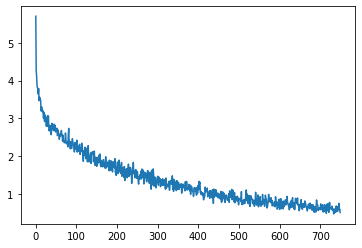

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.plot(plot_losses)

# Evaluate Model

Fra: elles sont la pour moi .
Eng (Real): they re here for me .
Eng (Trans): they re here for me . EOS


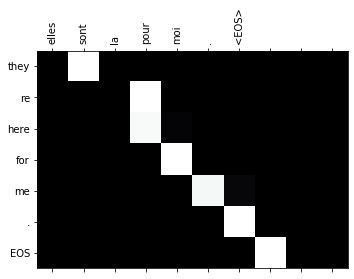

Fra: nous ne sommes toujours pas sures .
Eng (Real): we re still not sure .
Eng (Trans): we re still not sure . EOS


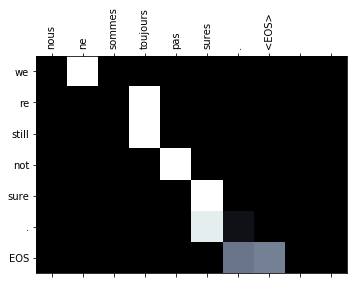

Fra: tu n es pas juste .
Eng (Real): you re not being fair .
Eng (Trans): you re not being fair . EOS


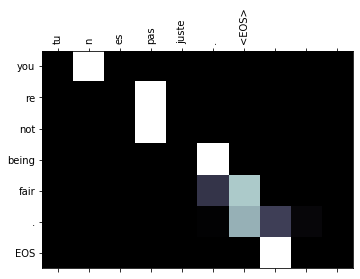

Fra: vous etes tres solitaires .
Eng (Real): you re very lonely .
Eng (Trans): you re very lonely . EOS


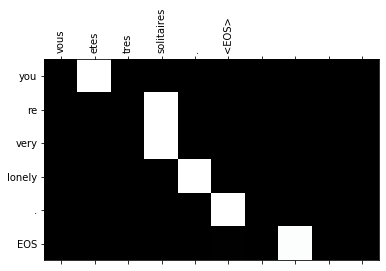

Fra: c est un faineant .
Eng (Real): he s a slacker .
Eng (Trans): he s a bigot . EOS


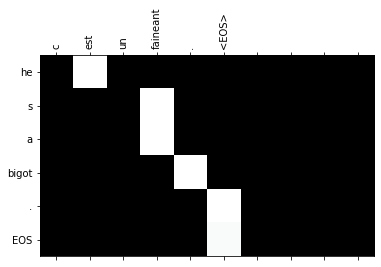

Fra: ils sont tous morts .
Eng (Real): they re all dead .
Eng (Trans): they re all dead . EOS


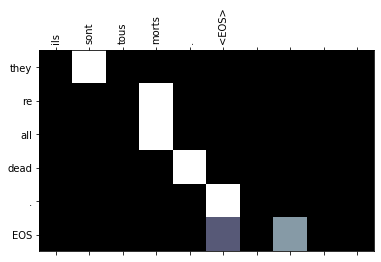

Fra: ils cherchent un bouc emissaire .
Eng (Real): they re looking for a scapegoat .
Eng (Trans): they re looking for a scapegoat . EOS


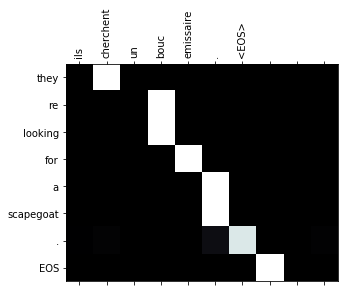

Fra: elle a peur du tonnerre .
Eng (Real): she is frightened of thunder .
Eng (Trans): she is afraid of a lot . EOS


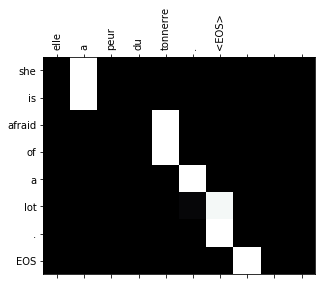

Fra: tu vas devoir appeler tom .
Eng (Real): you re going to have to call tom .
Eng (Trans): you re going to to call tom . EOS


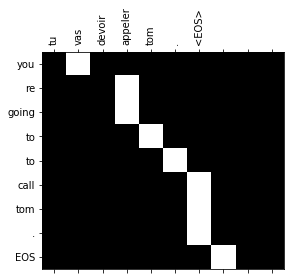

Fra: il n est pas vraiment un artiste .
Eng (Real): he is not much of an artist .
Eng (Trans): he is really an artist artist . EOS


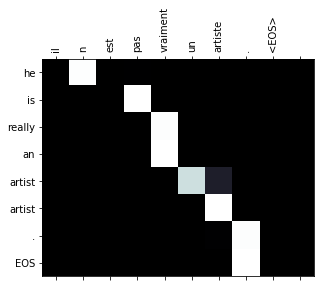

In [17]:
# Evaluate
encoder.eval()
decoder.eval()
for k in range(10):
    sent_idx = random.randint(0, len(pairs)-1)
    encoder_outs, decoder_attns = translate(encoder, decoder, train_set[sent_idx][0], teach_forcing_ratio=0)
    
    topv, topi = encoder_outs.topk(1)
    trans_res = ' '.join([out_lang.idx2word[i.item()] for i in topi.view(-1)])
    print('Fra:', pairs[sent_idx][0])
    print('Eng (Real):', pairs[sent_idx][1])
    print('Eng (Trans):', trans_res)
    
    if isinstance(decoder, AttnDecoderRNN):
        decoder_attns = torch.cat(decoder_attns).detach().numpy()

        fig, ax = plt.subplots()
        ax.matshow(decoder_attns, cmap='bone')
        ax.set_xticklabels([''] + pairs[sent_idx][0].split(' ') + ['<EOS>'], rotation=90)
        ax.set_yticklabels([''] + trans_res.split(' '))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.show()